# This notebook can be used to recreate the plots from the publication

Before you can run the plotting script you have to run the model once to generate a trace containing the sampled posterior distributions.

The default model used in the publication can be run with (it can take some time for that to finish):
```bash
python run_model.py
```

Feel free to take a look into the `run_model.py` script if you want to have a more detailed look into the model(s).


In [1]:
#imports

# Import covid19_inference toolbox from github submodule
# You can also install it with pip
import sys
sys.path.append("./covid19_inference")
import covid19_inference as cov19

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#from matplotlib.dates import DateFormatter,WeekdayLocator
import matplotlib
import pandas as pd
import numpy as np
import plot as pl
from rcParams import *
import pymc3 as pm
import pickle

## Overview figure

Figure 1 in the manuscript. Contains data overviw (panel a), reported cases with model fit (panel b), reproduction number (panel c), fraction of variant (panel d-g) and contribution to spread (panel i-h) plots.


In [2]:
# Define colors for different variants
# we will use the colors for more or less every figure
colors = {}
colors["B.1.1"] = "#648fff"
colors["B.1.1.348"] = "#ffb000"
colors["B.1.1.7"] = "#dc267f"
colors["C.37"] = "#fe6100"
colors["P.1"] = "#785ef0"
colors["unknown"] = "#D55E00"
colors["Total"] = "#000000"

In [3]:
""" Load model run
Please run the model if you haven't !
"""
# Which file do we want to load? Default should be selected
likelihood="dirichlet"
spreading_dynamics="kernelized_spread"
influx_factor=0.2

postfix_for_plots=f"_influx={influx_factor}"

# Import the samples from our model (i.e. the trace)
with open(f"./pickled/Variants-likelihood={likelihood}-spread_method={spreading_dynamics}-influx={influx_factor}_forecast.pickle", "rb") as f:
    model, trace = pickle.load(f)
    

def posterior_to_array(trace, key):
    """
    Convert posterior for a key into a numpy array. Flattens
    chain and draw dimensions in the arviz trace.
    """
    var = np.array(trace.posterior[key])
    var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    return var

In [4]:
# Load data weekly sequenced variants 
variants = pd.read_excel("./data/Chile_Variants_Updated_with_airports.xlsx",sheet_name="Variants_Count")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"
variants.index = pd.to_datetime(variants.index + '-1', format='%V_%G-%u')
variants = variants.iloc[0:-1]
variant_names = ["B.1.1", "B.1.1.348", "B.1.1.7", "C.37", "P.1", "unknown"]

# Load casenumbers chile and sum over weeks
jhu = cov19.data_retrieval.JHU(True)
new_cases_obs = jhu.get_new(country="Chile",data_begin=variants.index[0],data_end=model.data_end)

# Define rcparameters for the plotting
params = {'legend.fontsize': 8,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 9,
         'font.size': 8,
         'axes.titlesize':12,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'font.family':'sans-serif',
         'font.sans-serif':"arial",
         'figure.dpi': 150,
         'lines.linewidth':1.5,
         'lines.markersize':1.5
         }
matplotlib.rcParams.update(params)
plt.rcParams.update(params)

# Define major tick formatter (used by most of the timeseries plots)
major_ticks_locator= matplotlib.dates.MonthLocator(bymonthday=1)
date_form = matplotlib.dates.DateFormatter("1 %b")
days_forecast=21

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


<ipython-input-5-13362df1b51d>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=25)
<ipython-input-5-13362df1b51d>:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=25)
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 

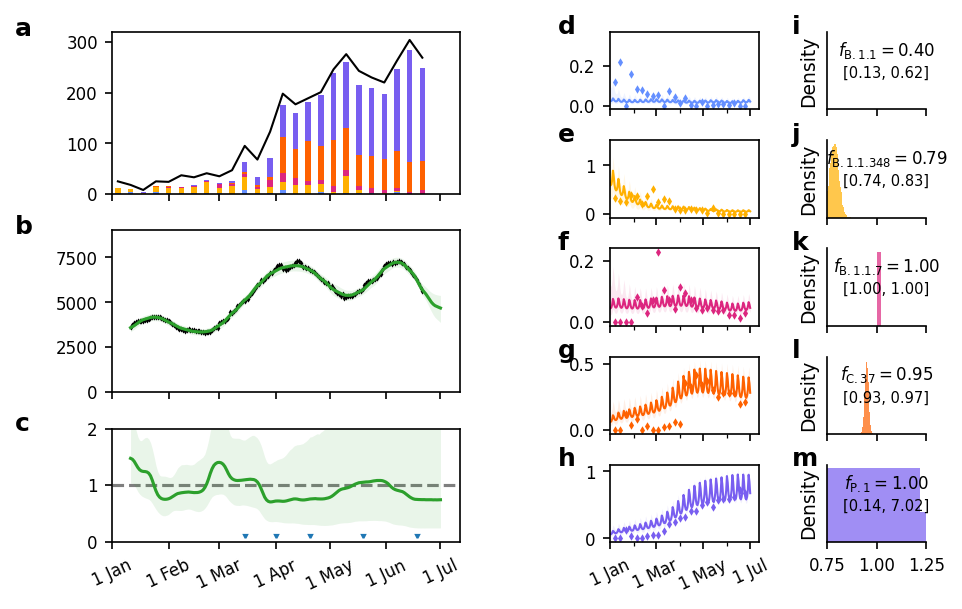

In [5]:
""" Plot lambda and casenumbers
"""

# Letters for panel indentification 
letters = ['a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
pos_letter = (-0.35, 0.98)
size_letter=12
pos_letter_factor_first_col = 0.8
weight_letter = 'bold'

# Figure and gridspecs for the layout
fig = plt.figure(figsize=(7,4.5))
gs0 = fig.add_gridspec(1, 2, wspace=0.45,width_ratios = [1.1,1])
gs00 = gs0[0].subgridspec(3, 1, height_ratios = [1,1,0.7], hspace=0.25)
gs01 = gs0[1].subgridspec(5, 2, width_ratios = [1.5,1], wspace=0.55, hspace=0.4)

date_range = pd.date_range(model.sim_begin, model.sim_end)
date_range_short = pd.date_range(model.data_begin, model.sim_end)
offset_short = model.diff_data_sim + 7

i_all = 0
axes = []
for i in range(3):
    axes.append(fig.add_subplot(gs00[i]))

""" Barplots (panel a)
"""
s=0
for c in variants.columns:
    if c == "N_Total":
        continue
    axes[0].bar(variants.index,variants[c],width=3,label=c,bottom=s,color=colors[c])
    s += variants[c]
    
# Total
axes[0] = cov19.plot._timeseries(
    x=variants.index,
    y=variants["N_Total"],
    what="model",
    color="black",
    ax=axes[0],
    label="Total",
    lw=1
)
axes[0].text(pos_letter[0]*pos_letter_factor_first_col, pos_letter[1], letters[i_all], transform=axes[0].transAxes, size=size_letter,  weight=weight_letter)
i_all += 1


""" Reported cases and model fit (panel b)
"""
# Calculate rolling average new_cases
nc = posterior_to_array(trace,"new_cases")
nc = pd.DataFrame(nc.T,index=pd.date_range(model.sim_begin,model.sim_end))

# Plot new cases (real)
cov19.plot._timeseries(
    x=new_cases_obs.index[7:],
    y=np.array(new_cases_obs.rolling(7).mean().T)[7:],
    what="data",
    ax=axes[1],
    color="black",
    markersize=0.7
)

# Plot new cases (model)
cov19.plot._timeseries(
    x=nc.index[offset_short:],
    y=np.array(nc.rolling(7).mean().T)[:,offset_short:],
    what="model",
    ax=axes[1]
)

axes[1].set_ylim(0,9000)
axes[1].text(pos_letter[0]*pos_letter_factor_first_col, pos_letter[1], letters[i_all], transform=axes[1].transAxes, size=size_letter,  weight=weight_letter)
i_all += 1


""" Reproduction number (panel c)
"""
R = posterior_to_array(trace,"base_lambda_t")
f = posterior_to_array(trace,"f_v")
unkn = posterior_to_array(trace,"unknown_lambda_t")
new_I = posterior_to_array(trace,"new_I_tv")
tau_spread = new_I/np.sum(new_I, axis=-1)[...,None]
S_t = posterior_to_array(trace,"S_t")
fact = S_t/model.N_population
R_eff = np.exp(np.sum(np.log(R[:,:,None]*f[:,None,:])*fact[...,None]*tau_spread[:,:,:-1] + (np.log(unkn*R)*fact*tau_spread[:,:,-1])[:,:,None], axis=-1))

cov19.plot._timeseries(
    x=date_range[offset_short:],
    y=R_eff[:,offset_short:],
    what="model",
    ax=axes[2]
)

axes[2].axhline(1, color='tab:grey', ls="--", zorder=-1)
axes[2].set_ylim(0,2)
axes[2].plot([datetime(2021,3,15),
               datetime(2021,4,1),
               datetime(2021,4,20),
               datetime(2021,5,19),
               datetime(2021,6,18),],
            [0.1 for _ in range(5)], 'v')
axes[2].text(pos_letter[0]*pos_letter_factor_first_col, pos_letter[1], letters[i_all], transform=axes[2].transAxes, size=size_letter,  weight=weight_letter)
i_all += 1

for i, ax in enumerate(axes):
    if i == 2:
        ax.set_xticklabels(ax.get_xticks(), rotation=25)
        ax.xaxis.set_major_formatter(date_form)
    else: 
        ax.set_xticklabels("")
    ax.xaxis.set_major_locator(major_ticks_locator)
    ax.minorticks_off()
    _ = ax.set_xlim(model.data_begin-timedelta(days=3), model.data_end+timedelta(days=days_forecast))


""" Fraction plots (panel d-g)
"""
axes = []
for i in range(5):
    axes.append(fig.add_subplot(gs01[i,0]))

for v, variant in enumerate(variant_names[:5]):
    ax = cov19.plot._timeseries(
        x=pd.date_range(model.sim_begin,model.sim_end),
        y=posterior_to_array(trace,"tau")[:,:,v],
        what="model",
        ax=axes[v],
        color=colors[variant],
        lw=1
    )
    if v == 5 :
        ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=(variants["N_Total"]-variants[variants.columns[0:5]].sum(axis=1))/variants["N_Total"],
            what="data",
            ax=ax,
            color=colors[variant],
            markersize=1.5,
            lw=1
        )       
    else:
        ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=variants[variants.columns[v]]/variants["N_Total"],
            what="data",
            ax=ax,
            color=colors[variant],
            markersize=1.5,
        )

for i, ax in enumerate(axes):
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=[1+2*i for i in range(6)],bymonthday=1))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(bymonth=[0+2*i for i in range(6)],bymonthday=1))
    if i == 4:
        ax.set_xticklabels(ax.get_xticks(), rotation=25)
        ax.xaxis.set_major_formatter(date_form)
    else:
        ax.set_xticklabels("")
    _ = ax.set_xlim(model.data_begin-timedelta(days=3), model.data_end+timedelta(days=days_forecast))
    
    ax.text(pos_letter[0], pos_letter[1], letters[i_all], transform=ax.transAxes, size=size_letter,  weight=weight_letter)
    i_all += 1

    

    
""" Contribution to spread (panel i-m)
"""

axes = []
for i in range(5):
    axes.append(fig.add_subplot(gs01[i,1]))

f = posterior_to_array(trace,"f_v")

fixed = "B.1.1.7"
off = 0 #offset

for v, variant in enumerate(variant_names[:-1]):
    axes[v].set_xlim(0.75,1.25)
    rcParams.color_posterior = colors[variant]
    pl._distribution(
        array_posterior=f[:, v] if not variant == fixed else 1,
        array_prior= None,
        dist_name="f_v",
        dist_math="f",
        suffix=f"{{\\mathrm{{{variant}}} }}",
        ax=axes[v],
        fontsize_median=8, 
        fontsize_CI=7,
    )
    if not v == 4:
        axes[v].set_xticklabels("")
    axes[v].set_ylabel(r"Density")
    axes[v].set_yticks([])
    axes[v].text(pos_letter[0], pos_letter[1], letters[i_all], transform=axes[v].transAxes, size=size_letter,  weight=weight_letter)
    i_all += 1

fig.savefig(f"figures/Figure_1_{postfix_for_plots}.png",dpi=300)
fig.savefig(f"figures/Figure_1_{postfix_for_plots}.pdf",dpi=300)

## Influx

Additional plots

<ipython-input-6-90741448e151>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=25)


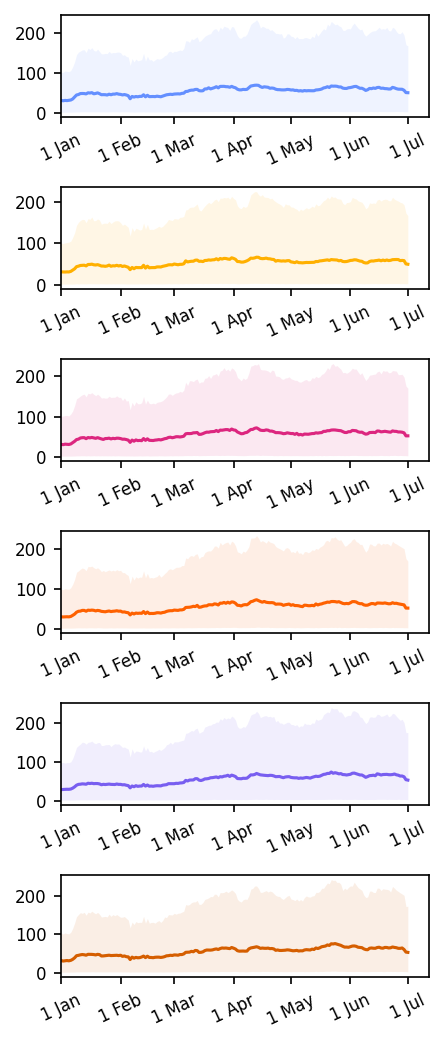

In [6]:
fig, axes = plt.subplots(6,1,figsize=(3,1.4*5))
Phi = posterior_to_array(trace,"Phi")

for v, v_name in enumerate(variant_names):
    cov19.plot._timeseries(
        x = pd.date_range(model.sim_begin,model.sim_end),
        y = Phi[:,:,v],
        color=colors[v_name],
        ax=axes[v],
        what="model"
    )

for a,ax in enumerate(axes):
    ax.set_xticklabels(ax.get_xticks(), rotation=25)
    #ax.set_title(variant_names[a])
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(major_ticks_locator)
    ax.minorticks_off()
    _ = ax.set_xlim(model.data_begin-timedelta(days=3), model.data_end+timedelta(days=days_forecast))
fig.tight_layout()

fig.savefig(f"./figures/2_influx{postfix_for_plots}.png",dpi=300)
fig.savefig(f"./figures/2_influx{postfix_for_plots}.pdf",dpi=300)

## Reporting delay

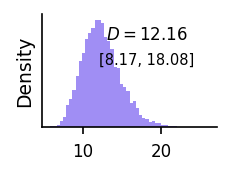

In [19]:
d = posterior_to_array(trace,"delay")
ax = pl._distribution(
    array_posterior=d,
    array_prior=None,
    dist_name="D",
    dist_math="D",
    suffix="",
    fontsize_median=8, 
    fontsize_CI=7,
)
ax.set_ylabel(r"Density")
ax.set_yticks([])

fig.tight_layout()

fig.savefig(f"./figures/3_delay{postfix_for_plots}.png",dpi=300)
fig.savefig(f"./figures/3_delay{postfix_for_plots}.pdf",dpi=300)

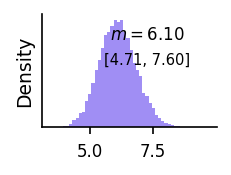

In [25]:
inc = posterior_to_array(trace,"median_incubation_v")
ax = pl._distribution(
    array_posterior=inc,
    array_prior=None,
    dist_name="m",
    dist_math="m",
    suffix="",
    fontsize_median=8, 
    fontsize_CI=7,
)
ax.set_ylabel(r"Density")
ax.set_yticks([])

fig.tight_layout()

fig.savefig(f"./figures/3_incubation{postfix_for_plots}.png",dpi=300)
fig.savefig(f"./figures/3_incubation{postfix_for_plots}.pdf",dpi=300)

In [81]:
""" Spllementary figure
"""

# Letters for panel indentification 
letters = ['a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
pos_letter = (-0.35, 0.98)
size_letter=12
pos_letter_factor_first_col = 0.8
weight_letter = 'bold'

# Figure and gridspecs for the layout
fig = plt.figure(figsize=(7,4.5))
gs0 = fig.add_gridspec(1, 2, wspace=0.45, width_ratios = [1,1])
gs00 = gs0[0].subgridspec(6, 1, hspace=0.3)
gs01 = gs0[1].subgridspec(3, 1, hspace=0.3)
gs02 = gs01[2].subgridspec(1, 3, wspace=0.55, hspace=0.4,)

date_range = pd.date_range(model.sim_begin, model.sim_end)
date_range_short = pd.date_range(model.data_begin, model.sim_end)
offset_short = model.diff_data_sim + 7

i_all = 0

"""Create plot for influx
"""

# Layout
axes = []
for i in range(6):
    axes.append(fig.add_subplot(gs00[i,0]))

# Get data from trace
Phi = posterior_to_array(trace,"Phi")

# Plot for each variant
for v, v_name in enumerate(variant_names):
    cov19.plot._timeseries(
        x = date_range[:],
        y = Phi[:,:,v],
        color=colors[v_name],
        ax=axes[v],
        what="model",    
    )
    
# X-Axis formatter and letters
for i, ax in enumerate(axes):
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=[1+2*i for i in range(6)],bymonthday=1))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(bymonth=[0+2*i for i in range(6)],bymonthday=1))
    if i == 5:
        ax.set_xticklabels(ax.get_xticks(), rotation=25)
        ax.xaxis.set_major_formatter(date_form)
    else:
        ax.set_xticklabels("")
        
    #Maybe adjust this:
    _ = ax.set_xlim(model.data_begin-timedelta(days=3), model.data_end+timedelta(days=days_forecast))
    
    ax.text(pos_letter[0], pos_letter[1], letters[i_all], transform=ax.transAxes, size=size_letter,  weight=weight_letter)
    i_all += 1
    
""" Other variants
"""
# Layout
axes = []
for i in range(2):
    axes.append(fig.add_subplot(gs01[i,0]))
    
unknown_lambda_t = posterior_to_array(trace,"unknown_lambda_t")
cov19.plot._timeseries(
    x = date_range[:],
    y = unknown_lambda_t,
    color="tab:green",
    ax=axes[0],
    what="model",    
)
axes[0].set_ylabel("R other variants")

tau = posterior_to_array(trace,"tau")
cov19.plot._timeseries( #model
    x = date_range[:],
    y = tau[:,:,5],
    color=colors["unknown"],
    ax=axes[1],
    what="model",    
)
cov19.plot._timeseries( #data
    x=variants.index + timedelta(days=3.5),
    y=(variants["N_Total"]-variants[variants.columns[0:5]].sum(axis=1))/variants["N_Total"],
    what="data",
    ax=axes[1],
    color=colors["unknown"],
    markersize=1.5,
    lw=1
)       
axes[1].set_ylabel(r"$\tau$ other variants")

# X-Axis formatter and letters
for i, ax in enumerate(axes):
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=[1+2*i for i in range(6)],bymonthday=1))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(bymonth=[0+2*i for i in range(6)],bymonthday=1))
    if i == 1:
        ax.set_xticklabels(ax.get_xticks(), rotation=25)
        ax.xaxis.set_major_formatter(date_form)
    else:
        ax.set_xticklabels("")
        
    #Maybe adjust this:
    _ = ax.set_xlim(model.data_begin-timedelta(days=3), model.data_end+timedelta(days=days_forecast))
    
    ax.text(pos_letter[0], pos_letter[1], letters[i_all], transform=ax.transAxes, size=size_letter,  weight=weight_letter)
    i_all += 1

    
""" Distribution plot delay
"""
# Layout
axes = []
for i in range(3):
    axes.append(fig.add_subplot(gs02[0,i]))
    
# Reporting delay
rcParams.color_posterior = "tab:green"

ax = axes[0]
d = posterior_to_array(trace,"delay")
prior_d = pm.sample_prior_predictive(
    samples=1000, model=model, var_names=["delay"]
)["delay"]
ax = pl._distribution(
    array_posterior=d,
    array_prior=prior_d,
    dist_name="D",
    dist_math="D",
    suffix="",
    fontsize_median=8, 
    fontsize_CI=7,
    ax=ax
)
ax.set_ylabel(r"Density")
ax.set_yticks([])
ax.text(pos_letter[0], pos_letter[1], letters[i_all], transform=ax.transAxes, size=size_letter,  weight=weight_letter)
i_all +=1

# Mean incubation
ax = axes[1]
d = posterior_to_array(trace,"median_incubation_v")
prior_d = pm.sample_prior_predictive(
    samples=1000, model=model, var_names=["median_incubation_v"]
)["median_incubation_v"]
ax = pl._distribution(
    array_posterior=d,
    array_prior=prior_d,
    dist_name="m",
    dist_math="m",
    suffix="",
    fontsize_median=8, 
    fontsize_CI=7,
    ax=ax
)
ax.set_ylabel(r"Density")
ax.set_yticks([])
ax.text(pos_letter[0], pos_letter[1], letters[i_all], transform=ax.transAxes, size=size_letter,  weight=weight_letter)
i_all +=1

# Omega
ax = axes[2]
d = posterior_to_array(trace,"factor_likelihood")
ax = pl._distribution(
    array_posterior=d,
    array_prior=None,
    dist_name="omega",
    dist_math="\omega",
    suffix="",
    fontsize_median=8, 
    fontsize_CI=7,
    ax=ax
)
ax.set_ylabel(r"Density")
""" f unknown only has the known variants for me
# (you can try if it works for you be increasing the gs02 column number by 1)
ax = axes[3]
f = posterior_to_array(trace,"f_v")
ax = pl._distribution(
    array_posterior=f[:,5],
    array_prior=None,
    dist_name="f",
    dist_math="f",
    suffix=f"{{\\mathrm{{{others}}} }}",
    fontsize_median=8, 
    fontsize_CI=7,
    ax=ax
)
ax.set_ylabel(r"Density")
ax.set_yticks([])
"""
ax.text(pos_letter[0], pos_letter[1], letters[i_all], transform=ax.transAxes, size=size_letter,  weight=weight_letter)
i_all +=1

fig.savefig(f"figures/Figure_S_{postfix_for_plots}.png",dpi=300)
fig.savefig(f"figures/Figure_S_{postfix_for_plots}.pdf",dpi=300)

TypeError: __init__() got an unexpected keyword argument 'left'

<Figure size 1050x675 with 0 Axes>

# 